In [0]:
!pip install mtcnn

In [0]:
!pip install git+https://github.com/rcmalli/keras-vggface.git

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-xm1zwpey
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-xm1zwpey
  Created wheel for keras-vggface: filename=keras_vggface-0.6-cp36-none-any.whl size=8311 sha256=b4ea1bcf94bd000017327de9f444cc05744c0108f6ce742ea0b8b62fc62ed29b
  Stored in directory: /tmp/pip-ephem-wheel-cache-_7ukiy7p/wheels/36/07/46/06c25ce8e9cd396dabe151ea1d8a2bc28dafcb11321c1f3a6d
Successfully built keras-vggface


In [0]:
from PIL import Image
from mtcnn.mtcnn import MTCNN
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pickle
from tensorflow.keras.utils import to_categorical
import os

Using TensorFlow backend.


In [0]:
DATA_FILE = "data_face.npz"
data = np.load(DATA_FILE)
data_X,data_y,num_class = data["arr_0"],data["arr_1"],data["arr_2"]
num_class = np.asscalar(num_class)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  after removing the cwd from sys.path.


In [0]:
data_X = data_X.reshape(data_X.shape[0], 224, 224 , 3)
data_y = data_y.reshape(data_y.shape[0], 1)
print(data_X.shape)
print(data_y.shape)
print(num_class)

(13224, 224, 224, 3)
(13224, 1)
76


In [0]:
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size = 0.2, shuffle = True)
print(X_train.shape)
print(y_train.shape)

(10579, 224, 224, 3)
(10579, 1)


In [0]:
X_val, y_val = X_train[8000:], y_train[8000:]
X_train, y_train = X_train[:8000], y_train[:8000]
y_train = to_categorical(y_train, num_class)
y_val = to_categorical(y_val, num_class)
y_test = to_categorical(y_test, num_class)
print(X_train.shape)
print(y_train.shape)

(8000, 224, 224, 3)
(8000, 76)


In [0]:
import keras
from keras import backend as K
import tensorflow as tf
from keras_vggface.vggface import VGGFace
from keras.layers import Dense,Flatten,Dropout,Input
from keras.models import Sequential,Model,load_model
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers

In [0]:
# Load model VGG 16 weights của vggface, include_top=False để bỏ phần Fully connected layer ở cuối.
baseModel = VGGFace(model='vgg16',weights='vggface', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# Xây thêm các layer
# Lấy output của ConvNet trong VGG16
fcHead = baseModel.output

# Flatten trước khi dùng FCs
fcHead = Flatten(name='flatten')(fcHead)

# Thêm FC
fcHead = Dense(256, activation='relu')(fcHead)
fcHead = Dropout(0.5)(fcHead)

# Output layer với softmax activation
fcHead = Dense(76, activation='softmax')(fcHead)

# Xây dựng model bằng việc nối ConvNet của VGG16 và fcHead
model  = Model(inputs=baseModel.input, outputs=fcHead)

In [0]:
# augmentation cho training data
aug_train = ImageDataGenerator(rescale=1./255, rotation_range=30, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.2, 
                         zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')
# augementation cho test
aug_test= ImageDataGenerator(rescale=1./255)

In [0]:
# freeze VGG model
for layer in baseModel.layers:
    layer.trainable = False
    
opt = keras.optimizers.RMSprop(0.001)
model.compile(opt, 'categorical_crossentropy', ['accuracy'])
numOfEpoch = 25
H = model.fit_generator(aug_train.flow(X_train, y_train, batch_size=32), 
                        steps_per_epoch=len(X_train)//32,
                        validation_data=(aug_test.flow(X_test, y_test, batch_size=32)),
                        validation_steps=len(X_test)//32,
                        epochs=numOfEpoch)

Epoch 1/25
250/250 [==============================] - 122s 488ms/step - loss: 3.9288 - accuracy: 0.1058 - val_loss: 2.6428 - val_accuracy: 0.4729
Epoch 2/25
250/250 [==============================] - 116s 464ms/step - loss: 2.9268 - accuracy: 0.3001 - val_loss: 1.6266 - val_accuracy: 0.6965
Epoch 3/25
250/250 [==============================] - 113s 451ms/step - loss: 2.3188 - accuracy: 0.4265 - val_loss: 1.3870 - val_accuracy: 0.7459
Epoch 4/25
250/250 [==============================] - 113s 453ms/step - loss: 1.9648 - accuracy: 0.5063 - val_loss: 1.1516 - val_accuracy: 0.8132
Epoch 5/25
250/250 [==============================] - 113s 452ms/step - loss: 1.7260 - accuracy: 0.5648 - val_loss: 0.5396 - val_accuracy: 0.8247
Epoch 6/25
250/250 [==============================] - 112s 449ms/step - loss: 1.5611 - accuracy: 0.5955 - val_loss: 0.3999 - val_accuracy: 0.8565
Epoch 7/25
250/250 [==============================] - 113s 453ms/step - loss: 1.4490 - accuracy: 0.6274 - val_loss: 0.6266 -

In [0]:
#test
scores = model.evaluate(X_test, y_test, verbose=1)
print("Acccuracy: ", 100*scores[1])
print("Loss: ", scores[0])

2645/2645 [==============================] - 24s 9ms/step
Acccuracy:  94.48015093803406
Loss:  40.51519584710066


In [0]:
model = load_model("finetuningvgg16.hdf5")

In [0]:
# unfreeze some last CNN layer:
for layer in baseModel.layers[15:]:
    layer.trainable = True

numOfEpoch = 35
opt = keras.optimizers.SGD(0.001)
model.compile(opt, 'categorical_crossentropy', ['accuracy'])
H = model.fit_generator(aug_train.flow(X_train, y_train, batch_size=32), 
                        steps_per_epoch=len(X_train)//32,
                        validation_data=(aug_test.flow(X_test, y_test, batch_size=32)),
                        validation_steps=len(X_test)//32,
                        epochs=numOfEpoch)

Epoch 1/35
250/250 [==============================] - 124s 498ms/step - loss: 0.8704 - accuracy: 0.7721 - val_loss: 0.0205 - val_accuracy: 0.9722
Epoch 2/35
250/250 [==============================] - 118s 472ms/step - loss: 0.7680 - accuracy: 0.7908 - val_loss: 0.0184 - val_accuracy: 0.9705
Epoch 3/35
250/250 [==============================] - 115s 458ms/step - loss: 0.7276 - accuracy: 0.8067 - val_loss: 0.0647 - val_accuracy: 0.9767
Epoch 4/35
250/250 [==============================] - 115s 460ms/step - loss: 0.7101 - accuracy: 0.8077 - val_loss: 0.2878 - val_accuracy: 0.9763
Epoch 5/35
250/250 [==============================] - 114s 454ms/step - loss: 0.6590 - accuracy: 0.8231 - val_loss: 0.0487 - val_accuracy: 0.9793
Epoch 6/35
250/250 [==============================] - 114s 455ms/step - loss: 0.6432 - accuracy: 0.8241 - val_loss: 0.0150 - val_accuracy: 0.9721
Epoch 7/35
250/250 [==============================] - 115s 460ms/step - loss: 0.6008 - accuracy: 0.8330 - val_loss: 0.0131 -

In [0]:
model.save('finetuningvgg16.hdf5')

In [0]:
#test
scores = model.evaluate(X_test, y_test, verbose=1)
print("Acccuracy: ", 100*scores[1])
print("Loss: ", scores[0])

2645/2645 [==============================] - 24s 9ms/step
Acccuracy:  98.67674708366394
Loss:  6.676836643174347


In [0]:
y_predict = model.predict(X_test)

In [0]:
predict_wrong = []
label_predict_wrong = []
for i in range(y_test.shape[0]):
  if np.argmax(y_predict[i]) != np.argmax(y_test[i]):
    predict_wrong.append(i)
    label_predict_wrong.append(np.argmax(y_predict[i]))

In [0]:
from  collections import Counter
print(sorted(Counter(label_predict_wrong).items()))

[(1, 2), (2, 1), (3, 2), (6, 1), (8, 1), (11, 1), (13, 1), (15, 1), (18, 3), (28, 2), (30, 1), (32, 2), (39, 1), (40, 4), (41, 1), (48, 1), (51, 1), (56, 2), (57, 1), (58, 1), (59, 1), (62, 2), (68, 1), (73, 1)]


In [0]:
# Load ouput_enc từ file để hiển thị nhãn
pkl_filename = 'data_y_enc.pkl'
with open(pkl_filename, 'rb') as file:
    output_enc = pickle.load(file)

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.22.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Name Idol predict: ['Mana Sakura']
Name Idol true: Mana Sakura


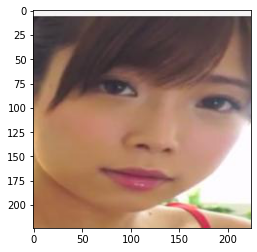

In [0]:
image = Image.open("test5.jpg")
image =image.convert("RGB")
plt.imshow(image)
image = np.asarray(image)
image = image.reshape(1,224,224,3)
predict = model.predict(image)

name_idol_true = "Mana Sakura"
name_idol_predict = output_enc.inverse_transform([np.argmax(predict)])
print("Name Idol predict: " + str(name_idol_predict ))
print("Name Idol true: " + name_idol_true)